In [2]:
import glob
import pylab as pl
import numpy as np
import matplotlib
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import desimodel
import desimeter

from   matplotlib.patches import Ellipse
from   astropy.time import Time
from   astropy.table import Table, vstack, join
from   desimodel.focalplane.geometry import xy2radec 
from   desimodel.io import load_fiberpos 
from   desitarget.geomask import circles
from   desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask, scnd_mask
from   desimeter.fiberassign import fiberassign_flat_xy2radec, radec2tan
from   fiberassign.hardware import xy2radec
from   fiberassign.hardware import load_hardware
from   desispec.maskbits import fibermask as fmsk
from   desispec.fiberbitmasking import get_all_fiberbitmask_with_amp

In [3]:
def tile2rosette(tile):
    if tile < 433:
        return (tile-1)//27
    else:
        if tile >= 433 and tile < 436:
            return 13
        if tile >= 436 and tile < 439:
            return 14
        if tile >= 439 and tile < 442:
            return 15
        if tile >= 442 and tile <=480:
            return (tile-442)//3
            
        if tile > 480:
            return tile//30    
    return 999999 #shouldn't be any more?

In [4]:
tiles = Table.read('/global/cscratch1/sd/mjwilson/S4MOCK/tiles-sv3.ecsv')
tiles = tiles[(tiles['STATUS'] == 'done') & (tiles['PROGRAM']=='BRIGHT')]
tiles['ROSETTE'] = np.array([tile2rosette(x) for x in tiles['TILEID']])
tiles

TILEID,PASS,RA,DEC,PROGRAM,IN_DESI,PRIORITY,STATUS,EBV_MED,DESIGNHA,DONEFRAC,AVAILABLE,ROSETTE
int64,int32,float64,float64,str6,bool,float64,str8,float32,float32,float32,bool,int64
12,0,150.04,2.286,BRIGHT,True,0.000e+00,done,0.022782475,0.00,1.0455,False,0
13,1,150.061,2.069,BRIGHT,True,0.000e+00,done,0.023243327,0.00,1.1505,False,0
14,2,150.212,2.226,BRIGHT,True,0.000e+00,done,0.022683823,0.00,1.0456,False,0
15,3,149.98,2.171,BRIGHT,True,0.000e+00,done,0.023039486,0.00,1.1052,False,0
16,4,150.187,2.099,BRIGHT,True,0.000e+00,done,0.023041949,0.00,1.0776,False,0
17,5,150.106,2.302,BRIGHT,True,0.000e+00,done,0.022638734,0.00,1.1865,False,0
18,6,149.993,2.237,BRIGHT,True,0.000e+00,done,0.022844847,0.00,1.4589,False,0
19,7,150.128,2.065,BRIGHT,True,0.000e+00,done,0.023041053,0.00,1.3565,False,0
20,8,150.17,2.28,BRIGHT,True,0.000e+00,done,0.02263027,0.00,1.1368,False,0


In [5]:
np.unique(tiles['ROSETTE'].data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [6]:
cmap = matplotlib.cm.get_cmap("magma", 20)

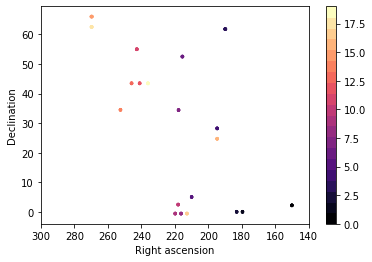

In [7]:
pl.scatter(tiles['RA'], tiles['DEC'], marker='.', lw=0.0, c=tiles['ROSETTE'], cmap=cmap)
pl.xlim(300., 140.)
pl.xlabel('Right ascension')
pl.ylabel('Declination')
pl.colorbar()

In [8]:
# glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')

In [9]:
ledger = vstack([Table.read(x) for x in glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')])

In [16]:
fbas      = sorted(glob.glob(root + '/' + '20210405' + '/fba-*.fits'))
x = fits.open(fbas[0])
x[1].data

FITS_rec([( 400, 39627841603634505,    0,  0, 5400., 0,   0, 'POS', 150.04315639, 2.17283698, 1179714, 1,   -0.7366056,  -27.49958 ),
          ( 449, 39627841603634766,    1,  0, 5400., 0,   1, 'POS', 150.0520835 , 2.12664752, 2162697, 1,   -2.892863 ,  -38.73417 ),
          ( 420, 39627841603633806,    2,  0, 5400., 0,   2, 'POS', 150.01884814, 2.15325261, 2162697, 1,    5.171768 ,  -32.254963),
          ...,
          (4944, 39627811417227872, 9524,  0, 5400., 9, 524, 'POS', 150.77684464, 0.88856278, 2162697, 1, -186.26451  , -354.15414 ),
          (4909, 39627805373240341, 9525,  0, 5400., 9, 525, 'POS', 150.73203451, 0.86511692, 2162697, 1, -174.91522  , -360.09848 ),
          (4900,            -14546, 9526, 11, 5400., 9, 526, 'POS', 150.69741876, 0.86528892,       0, 0, -166.01378  , -359.76123 )],
         dtype=(numpy.record, [('FIBER', '>i4'), ('TARGETID', '>i8'), ('LOCATION', '>i4'), ('FIBERSTATUS', '>i4'), ('LAMBDA_REF', '>f4'), ('PETAL_LOC', '>i2'), ('DEVICE_LOC', '>i4'

In [17]:
ledger

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
deg,deg,yr,mas,mas / yr,mas / yr,,,,,,,,,,,,,,,,s,,
float64,float64,float32,float32,float32,float32,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,float64,int64,int32,str30,str19,str6,int64
196.62742006672016,24.860651386169796,2015.5,0.36841992,-1.8383924,-11.432665,39628368185919695,2305843009213693952,0,1280,0.8815223938654961,516,101500,9,0,9,0,-1.0,-1,-1,MWS|UNOBS,2021-04-04T23:05:51,0.57.0,101500
196.63386250226426,24.86194293534886,2015.5,0.8336445,-17.19976,-17.32398,39628368185919804,2305843009213693952,0,33,0.2671050026411076,516,101400,9,0,9,0,-1.0,-1,-1,MWS|UNOBS,2021-04-04T23:05:51,0.57.0,101400
196.63429360212476,24.8714520556768,0.0,0.0,0.0,0.0,39628368185919813,1152921504606846976,65537,0,0.4139456255358801,516,102000,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:51,0.57.0,102000
196.64435818950898,24.848514017272407,0.0,0.0,0.0,0.0,39628368185920019,1152921504606846976,65545,0,0.13968122668329153,516,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:51,0.57.0,102100
196.65245993047523,24.852865796704236,0.0,0.0,0.0,0.0,39628368185920150,1152921504606846976,65537,0,0.8662120004527031,516,102000,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:51,0.57.0,102000
196.65425852776548,24.855988968113266,0.0,0.0,0.0,0.0,39628368185920176,1152921504606912513,131074,0,0.16775986443658297,517,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:51,0.57.0,102100
196.65518175429455,24.871909587521976,0.0,0.0,0.0,0.0,39628368185920198,1152921504606846976,65537,0,0.2722904710676206,516,102000,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:51,0.57.0,102000
196.6582707274816,24.860118232683767,0.0,0.0,0.0,0.0,39628368185920254,1152921504609009673,131074,0,0.982337166034482,517,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:51,0.57.0,102100


In [9]:
np.mean(ledger['PRIORITY_INIT'] == ledger['PRIORITY'])

0.6553668048332207

In [10]:
ledger    = ledger[ledger['PRIORITY_INIT'] == ledger['PRIORITY']]

In [11]:
len(ledger) / 1.e6

1.448765

In [12]:
tileids      = tiles['TILEID'].data[tiles['ROSETTE'] == 15]
tileids

array([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427])

In [12]:
root      = '/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN/'

In [14]:
nights    = [x.split('/')[-1] for x in sorted(glob.glob(root + '/*'))]
nights.remove('SV3.ecsv')
nights

['20210405',
 '20210407',
 '20210408',
 '20210409',
 '20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417',
 '20210418',
 '20210419',
 '20210420',
 '20210422',
 '20210429',
 '20210430',
 '20210501',
 '20210502',
 '20210503',
 '20210504',
 '20210505',
 '20210506',
 '20210507',
 '20210508',
 '20210509',
 '20210510',
 '20210511',
 '20210512',
 '20210513',
 '20210514',
 '20210518',
 '20210521',
 '20210529']

In [15]:
fp            = load_fiberpos() 
fp.sort('LOCATION')

In [16]:
patrol_radii  = 1.48/60. # degrees 

In [17]:
tile_radii    = desimodel.focalplane.geometry.get_tile_radius_deg()
tile_radii

1.6280324520485583

In [18]:
def radec2standard(ra, dec, tile_ra, tile_dec):
    # https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Book%3A_Celestial_Mechanics_(Tatum)/11%3A_Photographic_Astrometry/11.02%3A_Standard_Coordinates_and_Plate_Constants
    _ra       = np.radians(ra)
    _dec      = np.radians(dec)
    _tra      = np.radians(tile_ra)
    _tdec     = np.radians(tile_dec)
    
    xi        = np.sin(_ra - _tra) / (np.sin(_tdec) * np.tan(_dec) + np.cos(_tdec) * np.cos(_ra - _tra))
    eta       = (np.tan(_dec) - np.tan(_tdec) * np.cos(_ra - _tra)) / (np.tan(_tdec) * np.tan(_dec) + np.cos(_ra - _tra)) 
    
    return xi, eta

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [20]:
rundate        = '2019-03-17T23:20:01' 
# rundate      = '2021-03-17T23:20:01'

hw             = load_hardware(rundate=rundate)

20210405 [417]
/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN//20210405/fba-000417.fits


Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec


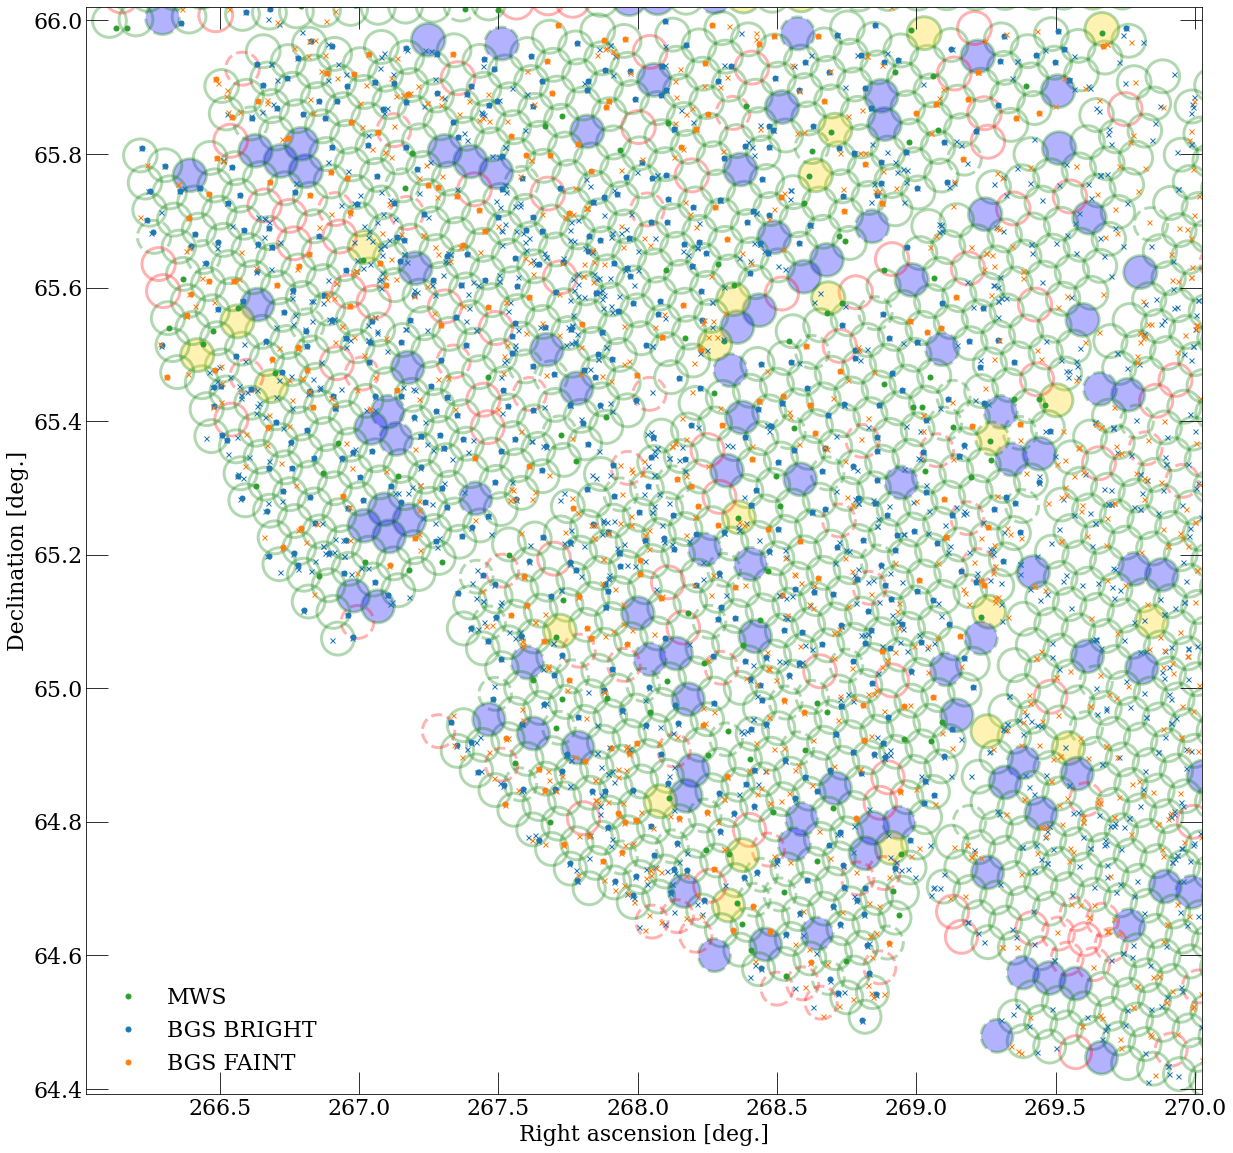

<Figure size 432x288 with 0 Axes>

In [26]:
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)

for night in nights:
    fbas      = sorted(glob.glob(root + '/' + night + '/fba-*.fits'))
    ts        = np.array([x.split('/')[-1].replace('.fits','').replace('fba-','') for x in fbas]).astype(np.int64)
    
    ts        = ts[np.isin(ts, tileids)]
    
    print(night, ts)
    
    if len(ts) == 0:
        continue

    fig, axes = plt.subplots(len(ts), 1, figsize=(20*len(ts),20))

    if len(ts) == 1:
        axes  = np.array([axes])

    for i, tid in enumerate(ts):
        fpath    = root + '/' + night + '/fba-{:06d}.fits'.format(tid)
        # tpath  = root + '/' + night + '/{:06d}-targ.fits'.format(tid)

        print(fpath)
        
        hdr       = fits.open(fpath)[1].header
        
        tra       = hdr['TILERA']                                                  
        tdec      = hdr['TILEDEC']                                           
        fieldrot  = hdr['FIELDROT']                                                
        fa_plan   = hdr['FA_PLAN']
        fa_run    = hdr['FA_RUN']
        fa_ha     = hdr['FA_HA']                                                           
        
        hw        = load_hardware(rundate=fa_run)
        
        tt        = Time(fa_run, format='isot', scale='utc')
        fba_mjd   = tt.mjd 
        
        tra       = fits.open(fpath)[1].header['TILERA']
        tdec      = fits.open(fpath)[1].header['TILEDEC']
                
        # targ    = Table.read(tpath)
        fba       = Table.read(fpath, hdu='FASSIGN')
        ftarg     = Table.read(fpath, hdu='FTARGETS')
        favl      = Table.read(fpath, hdu='FAVAIL')
        
        fba       = fba[fba['DEVICE_TYPE'] != 'ETC']
        
        # Unbelieveably, join alters the row order.  Not sure I knew this ...
        fba       = join(fba,  ledger, keys='TARGETID', join_type='left')
        favl      = join(favl, ledger, keys='TARGETID', join_type='left')
        
        in_ledger = ~fba['RA'].mask
        
        fba.sort('LOCATION')
        
        assert np.all(fp['LOCATION'].data == fba['LOCATION'].data)
        
        # pretty sure above does same thing so why go to the effort of doing this 
        targ_ras, targ_decs = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, fba['FIBERASSIGN_X'], fba['FIBERASSIGN_Y'], use_cs5=False)

        # Note broken fibers can be used as skies, so we don't assume fiberstatus == 0.
        standard   = (fba['FA_TYPE'].data & 2)  != 0
        sky        = (fba['FA_TYPE'].data & 4)  != 0  
        safe       = (fba['FA_TYPE'].data & 8)  != 0  
        supp       = (fba['FA_TYPE'].data & 16) != 0
        
        secondary  = (fba['SV3_SCND_TARGET'].data > 0)
        bgs        = (fba['SV3_DESI_TARGET'] & desi_mask['BGS_ANY']) != 0
        
        bgs_bright = (fba['SV3_BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0
        bgs_faint  = (fba['SV3_BGS_TARGET'] & bgs_mask['BGS_FAINT']) != 0
        bgs_hip    = (fba['SV3_BGS_TARGET'] & bgs_mask['BGS_FAINT_HIP']) != 0
        
        mws        = (fba['SV3_DESI_TARGET'] & desi_mask['MWS_ANY']) != 0
        
        unassigned = (fba['FIBERSTATUS'].data & 2**fmsk.bitnum('UNASSIGNED')) != 0
        stuck      = (fba['FIBERSTATUS'].data & 2**fmsk.bitnum('STUCKPOSITIONER')) != 0
        broken     = (fba['FIBERSTATUS'].data & 2**fmsk.bitnum('BROKENFIBER')) != 0
        restricted = (fba['FIBERSTATUS'].data & 2**fmsk.bitnum('RESTRICTED')) != 0
            
        good_fba   = (fba['FIBERSTATUS'] == 0) | (restricted & ~stuck & ~broken)

        unassigned = unassigned & ~stuck & ~broken
        restricted = restricted & ~stuck & ~broken & ~unassigned
            
        # ra, dec  = xy2radec(tra, tdec, fp["X"], fp["Y"])

        # assumes x,y are flat focal plane coordinates
        # ras, decs = fiberassign_flat_xy2radec(fp['X'], fp['Y'], tra, tdec, fba_mjd, fa_ha, fieldrot, from_platemaker=False)
    
        # https://github.com/desihub/fiberassign/blob/a3abb8758ddff19f7d256885ad4dfa83f787bd7f/py/fiberassign/hardware.py#L408
        # xy2radec(hw, tile_ra, tile_dec, tile_obstime, tile_obstheta, tile_obsha, x, y, use_cs5, threads=0)
                
        ells = []
        
        locs = sorted(hw.loc_pos_cs5_mm.keys())
        locs = [loc for loc in locs if hw.loc_device_type[loc] == 'POS']
        
        xys  = np.array([hw.loc_pos_cs5_mm[loc] for loc in locs])
        
        # Here we take the model hardware state for an early run date 2019-03-17T23:20:01 (to get home positions).
        ras, decs       = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, xys[:,0], xys[:,1], use_cs5=True)
        
        # Here we loop over fiber home locations, and plot according to their status. 
        for loccount, loc in enumerate(locs):
            ra          = ras[loccount]
            dec         = decs[loccount]
            
            # https://en.wikipedia.org/wiki/Angular_distance
            #
            # At fixed dec, change in ra for patrol radii is:
            patrol_dra  = patrol_radii / np.cos(np.radians(dec))
        
            # At fixed ra, change in dec for patrol radii is:
            patrol_ddec = patrol_radii
            
            e           = Ellipse(xy=(ra, dec),
                                  width=2. * patrol_dra, height=2. * patrol_ddec,
                                  angle=0.0)
    
            ells.append(e)
        
            axes[i].add_artist(e)
            
            e.set_clip_box(axes[i].bbox)
            e.set_alpha(0.3)
            e.set_facecolor('None')
            
            # working fiber, but restricted.  successfully assigned.
            if restricted[loccount]:
                e.set_edgecolor('g')
                e.set_linestyle('--')
 
            # working fiber.  not successfully assigned.
            elif unassigned[loccount]:
                e.set_edgecolor('r')
                e.set_linestyle('--')

            # working fiber.  successfully assigned and not restricted.
            elif good_fba[loccount]:
                e.set_edgecolor('g')
            
            else:
                e.set_edgecolor('red')
            
            e.set_linewidth(3)
    
            # If sky, we override with blue.  Can happen for both good and bad fibers.
            if sky[loccount] | supp[loccount]:
                e.set_facecolor('blue')
                
            if standard[loccount]:
                e.set_facecolor('gold')
            
            if safe[loccount]:
                e.set_facecolor('cyan')
            
            tids = []
            
            if in_ledger[loccount]:
                # --- Targets ---
                if bgs_bright[loccount]:
                    tids += fba['TARGETID'].data[bgs_bright[loccount]].tolist()
                
                    axes[i].plot(targ_ras[loccount], targ_decs[loccount], marker='.', lw=0.0, markersize=10, alpha=1., c=colors[0], label='BGS BRIGHT')

                elif bgs_faint[loccount]:
                    tids += fba['TARGETID'].data[bgs_faint[loccount]].tolist()
                
                    axes[i].plot(targ_ras[loccount], targ_decs[loccount], marker='.', lw=0.0, markersize=10, alpha=1., c=colors[1], label='BGS FAINT')
                
                elif mws[loccount]:
                    tids += fba['TARGETID'].data[mws[loccount]].tolist()
                
                    axes[i].plot(targ_ras[loccount], targ_decs[loccount], marker='.', lw=0.0, markersize=10, alpha=1., c=colors[2], label='MWS')
                
                # To be secondaries here, they were found in the ledger to get scnd. bit mask, so also main survey style targets. 
                elif secondary[loccount]:
                    tids += fba['TARGETID'].data[secondary[loccount]].tolist()
                
                    axes[i].plot(targ_ras[loccount], targ_decs[loccount], marker='.', lw=0.0, markersize=10, alpha=1., c=colors[3], label='SCND')
            
                else:
                    pass
        
        tids = np.array(tids)
        
        for itype, ttype in enumerate(['BRIGHT', 'FAINT']):
            is_type = (favl['SV3_BGS_TARGET'].data & bgs_mask['BGS_{}'.format(ttype)]) != 0
            is_type = is_type & ~favl['RA'].mask
            is_type = is_type & ~np.isin(favl['TARGETID'].data, tids)
        
            axes[i].plot(favl['RA'].data[is_type].data, favl['DEC'].data[is_type].data, marker='x', lw=0.0, markersize=5, alpha=1., c=colors[itype], label='')
            
        left=tra-tile_radii / np.cos(np.radians(tdec))
        bottom=tdec-tile_radii
            
        axes[i].set_xlim(right=tra, left=left)
        axes[i].set_ylim(top=tdec, bottom=bottom)        
        
        handles, labels = axes[i].get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        axes[i].legend(*zip(*unique), frameon=False)
        
        break
    
    pl.xlabel('Right ascension [deg.]')
    pl.ylabel('Declination [deg.]')        
    #pl.title('Tiles {} on night {}'.format(ts, night))
    pl.savefig('FBA_plot.png')
    pl.show()
    pl.clf()
    
    
    break

In [22]:
favl.dtype.names

('LOCATION',
 'FIBER',
 'TARGETID',
 'RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

In [23]:
ledger.dtype.names

('RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'TARGETID',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

In [30]:
desi_mask.names()

['LRG',
 'ELG',
 'QSO',
 'LRG_LOWDENS',
 'QSO_HIZ',
 'ELG_LOP',
 'ELG_HIP',
 'LRG_NORTH',
 'ELG_NORTH',
 'QSO_NORTH',
 'ELG_LOP_NORTH',
 'ELG_HIP_NORTH',
 'LRG_LOWDENS_NORTH',
 'LRG_SOUTH',
 'ELG_SOUTH',
 'QSO_SOUTH',
 'ELG_LOP_SOUTH',
 'ELG_HIP_SOUTH',
 'LRG_LOWDENS_SOUTH',
 'SKY',
 'STD_FAINT',
 'STD_WD',
 'STD_BRIGHT',
 'BAD_SKY',
 'SUPP_SKY',
 'NO_TARGET',
 'BRIGHT_OBJECT',
 'IN_BRIGHT_OBJECT',
 'NEAR_BRIGHT_OBJECT',
 'BGS_ANY',
 'MWS_ANY',
 'SCND_ANY']

In [40]:
scnd_mask.names()

['VETO',
 'UDG',
 'FIRST_MALS',
 'QSO_RED',
 'MWS_CLUS_GAL_DEEP',
 'LOW_MASS_AGN',
 'FAINT_HPM',
 'LOW_Z_TIER1',
 'LOW_Z_TIER2',
 'LOW_Z_TIER3',
 'BHB',
 'SPCV',
 'DC3R2_GAMA',
 'PSF_OUT_BRIGHT',
 'PSF_OUT_DARK',
 'HPM_SOUM',
 'SN_HOSTS',
 'GAL_CLUS_BCG',
 'GAL_CLUS_2ND',
 'GAL_CLUS_SAT',
 'STRONG_LENS',
 'WISE_VAR_QSO',
 'Z5_QSO',
 'MWS_MAIN_CLUSTER_SV',
 'BRIGHT_HPM',
 'WD_BINARIES_BRIGHT',
 'WD_BINARIES_DARK',
 'PV_BRIGHT_HIGH',
 'PV_BRIGHT_MEDIUM',
 'PV_BRIGHT_LOW',
 'PV_DARK_HIGH',
 'PV_DARK_MEDIUM',
 'PV_DARK_LOW',
 'BRIGHT_TOO_LOP',
 'BRIGHT_TOO_HIP',
 'DARK_TOO_LOP',
 'DARK_TOO_HIP']

In [33]:
ledger.dtype.names

('RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'TARGETID',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

In [41]:
scnd_notsv3  =  (ledger['SV3_SCND_TARGET'].data > 0)
scnd_notsv3 &= ((ledger['SV3_DESI_TARGET'].data & desi_mask['BGS_ANY']) == 0)
scnd_notsv3 &= ((ledger['SV3_DESI_TARGET'].data & desi_mask['MWS_ANY']) == 0)

scnd_notsv3  = ledger[scnd_notsv3]
scnd_notsv3

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
deg,deg,yr,mas,mas / yr,mas / yr,,,,,,,,,,,,,,,,s,,
float64,float64,float32,float32,float32,float32,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,float64,int64,int32,str30,str19,str6,int64
207.71349585787186,4.095958407215915,2015.5,0.37474668,-2.2474825,-4.027906,39627884817552081,4611686061377060864,0,0,0.45502144692493907,63,1998,1,2199023255552,1,0,-1.0,-1,-1,SCND|UNOBS,2021-04-04T23:14:15,0.57.0,1998
218.68818505702177,34.377367678517096,2015.5,0.23563902,2.0083709,-21.928774,39632971430366591,4611686061377060864,0,0,0.8153711478129937,63,1998,1,2199123918848,1,0,-1.0,-1,-1,SCND|UNOBS,2021-04-04T23:05:09,0.57.0,1998
213.59868744742795,-1.6643082026605303,2015.5,0.50522244,-43.182053,-3.4812536,39627746032224323,4611686061377060864,0,0,0.9188288041803259,63,1998,1,2199023255552,1,0,-1.0,-1,-1,SCND|UNOBS,2021-04-04T23:14:10,0.57.0,1998


In [43]:
for x in ['STD_FAINT', 'STD_WD', 'STD_BRIGHT']:
    y = (scnd_notsv3['SV3_DESI_TARGET'].data & desi_mask[x]) != 0
    
    print('{}\t{}'.format(x.ljust(15), y))

STD_FAINT      	[ True  True  True]
STD_WD         	[False False False]
STD_BRIGHT     	[ True  True  True]


In [23]:
for name in fmsk.names():
    print('{}\t{}\t{}'.format(name.ljust(20),\
                              fmsk.bitnum(name),\
                              np.count_nonzero((fba['FIBERSTATUS'].data & 2**fmsk.bitnum(name)) != 0)))

UNASSIGNED          	0	552
STUCKPOSITIONER     	1	334
BROKENFIBER         	2	19
RESTRICTED          	3	577
MISSINGPOSITION     	8	0
BADPOSITION         	9	0
POORPOSITION        	10	0
LOWEFFTIME          	15	0
BADFIBER            	16	0
BADTRACE            	17	0
BADFLAT             	18	0
BADARC              	19	0
MANYBADCOL          	20	0
MANYREJECTED        	21	0
BADAMPB             	22	0
BADAMPR             	23	0
BADAMPZ             	24	0
BADPETALPOS         	25	0
BADPETALSKY         	26	0
BADPETALSTDSTAR     	27	0
BADPETALFLUXCAL     	28	0
BADPETALSNR         	29	0
BADREADNOISE        	30	0
RESERVED31          	31	0


In [24]:
#define TARGET_TYPE_SCIENCE 1
#define TARGET_TYPE_STANDARD 2
#define TARGET_TYPE_SKY 4
#define TARGET_TYPE_SAFE 8
#define TARGET_TYPE_SUPPSKY 16

In [25]:
for ii in [1, 2, 4, 8, 16]:
    c = np.count_nonzero((fba['FA_TYPE'].data & ii) != 0)
    
    print('{}\t{}'.format(ii, c))

1	4044
2	102
4	401
8	2
16	0


# Done.